# Intro

In [1]:
import numpy as np
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from mypyext import extensions

rng = np.random.default_rng(42)

In [2]:

# 1) Veri üretelim (biraz gürültülü, model seçimi hissedilsin)
X, y = make_classification(
    n_samples=6000,
    n_features=25,
    n_informative=8,
    n_redundant=5,
    flip_y=0.06,         
    class_sep=0.9,
    random_state=42
)

In [3]:
y.valuecounts_()

array([[   0, 2995],
       [   1, 3005]])

In [11]:
#model tanımlama ve değerlendirme fonksiyonları + parametre gridleri
def make_model(C: float, l1_ratio: float):
    # solver seçimi: l1 için liblinear, l2 için lbfgs
    if l1_ratio == 1.0:
        solver="liblinear"
    else:  
        solver="lbfgs"
    clf = LogisticRegression(C=C, l1_ratio=l1_ratio, solver=solver, max_iter=2000)
   
    return Pipeline([
        ("scaler", StandardScaler()),
        ("clf", clf)
    ])
 

def evaluate(model, Xtrain, ytrain, Xtest, ytest):
    # hem eğitim hem değerlendirme
    model.fit(Xtrain, ytrain)
    if Xtest is None or ytest is None:
        return model, None
    pred = model.predict(Xtest)
    return model, accuracy_score(ytest, pred) 

c_grid = [0.01, 0.03, 0.1, 0.3, 1, 3, 10]
l1_ratio_grid = [0.0, 1.0]  # l1 için 1.0, l2 için 0.0

# train - test(holdout)

In [5]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [6]:
list(map(len, (X, X_train, X_test, y, y_train, y_test)))

[6000, 4800, 1200, 6000, 4800, 1200]

In [ ]:
best_val = -1
best_cfg = None
best_model = None

for C in c_grid:
    for l1_ratio in l1_ratio_grid:
        m = make_model(C, l1_ratio)
        _, val_acc = evaluate(m, X_train, y_train, X_test, y_test)
        if val_acc > best_val:
            best_val = val_acc
            best_cfg = (C, l1_ratio)
            best_model = m
 

print(f"Seçilen (C, l1_ratio) = {best_cfg}")
print(f"Test acc: {best_val:.4f}")

# Seçilen modeli train+test ile yeniden eğitiyoruz, bir daha test etmeye gerek yok 
# ama bizim fonksiyonumuz yine de test edecek, skor sonucuyla ilgilenmemek için _ geçiyoruz, sadece nihai modeli alıyoruz
X_train_final = np.vstack([X_train, X_test])
y_train_final = np.hstack([y_train, y_test])
final_model, _ = evaluate(best_model, X_train_final, y_train_final, None, None) #pickle yapılıp deploy edilir

Seçilen (C, l1_ratio) = (0.3, 1.0)
Test acc: 0.6517


In [8]:
final_model

,"steps steps: list of tuplesList of (name of step, estimator) tuples that are to be chained insequential order. To be compatible with the scikit-learn API, all stepsmust define `fit`. All non-last steps must also define `transform`. See:ref:`Combining Estimators ` for more details.","[('scaler', ...), ('clf', ...)]"
,"transform_input transform_input: list of str, default=NoneThe names of the :term:`metadata` parameters that should be transformed by thepipeline before passing it to the step consuming it.This enables transforming some input arguments to ``fit`` (other than ``X``)to be transformed by the steps of the pipeline up to the step which requiresthem. Requirement is defined via :ref:`metadata routing `.For instance, this can be used to pass a validation set through the pipeline.You can only set this if metadata routing is enabled, which youcan enable using ``sklearn.set_config(enable_metadata_routing=True)``... versionadded:: 1.6",None
,"memory memory: str or object with the joblib.Memory interface, default=NoneUsed to cache the fitted transformers of the pipeline. The last stepwill never be cached, even if it is a transformer. By default, nocaching is performed. If a string is given, it is the path to thecaching directory. Enabling caching triggers a clone of the transformersbefore fitting. Therefore, the transformer instance given to thepipeline cannot be inspected directly. Use the attribute ``named_steps``or ``steps`` to inspect estimators within the pipeline. Caching thetransformers is advantageous when fitting is time consuming. See:ref:`sphx_glr_auto_examples_neighbors_plot_caching_nearest_neighbors.py`for an example on how to enable caching.",None
,"verbose verbose: bool, default=FalseIf True, the time elapsed while fitting each step will be printed as itis completed.",False
,"copy copy: bool, default=TrueIf False, try to avoid a copy and do inplace scaling instead.This is not guaranteed to always work inplace; e.g. if the data isnot a NumPy array or scipy.sparse CSR matrix, a copy may still bereturned.",True
,"with_mean with_mean: bool, default=TrueIf True, center the data before scaling.This does not work (and will raise an exception) when attempted onsparse matrices, because centering them entails building a densematrix which in common use cases is likely to be too large to fit inmemory.",True
,"with_std with_std: bool, default=TrueIf True, scale the data to unit variance (or equivalently,unit standard deviation).",True
,"penalty penalty: {'l1', 'l2', 'elasticnet', None}, default='l2'Specify the norm of the penalty:- `None`: no penalty is added;- `'l2'`: add a L2 penalty term and it is the default choice;- `'l1'`: add a L1 penalty term;- `'elasticnet'`: both L1 and L2 penalty terms are added... warning:: Some penalties may not work with some solvers. See the parameter `solver` below, to know the compatibility between the penalty and solver... versionadded:: 0.19 l1 penalty with SAGA solver (allowing 'multinomial' + L1).. deprecated:: 1.8 `penalty` was deprecated in version 1.8 and will be removed in 1.10. Use `l1_ratio` instead. `l1_ratio=0` for `penalty='l2'`, `l1_ratio=1` for `penalty='l1'` and `l1_ratio` set to any float between 0 and 1 for `'penalty='elasticnet'`.",'deprecated'
,"C C: float, default=1.0Inverse of regularization strength; must be a positive float.Like in support vector machines, smaller values specify strongerregularization. `C=np.inf` results in unpenalized logistic regression.For a visual example on the effect of tuning the `C` parameterwith an L1 penalty, see::ref:`sphx_glr_auto_examples_linear_model_plot_logistic_path.py`.",0.3
,"l1_ratio l1_ratio: float, default=0.0The Elastic-Net mixing parameter, with `0 <= l1_ratio <= 1`. Setting`l1_ratio=1` gives a pure L1-penalty, setting `l1_ratio=0` a pure L2-penalty.Any value between 0 and 1 gives an Elastic-Net penalty of the form`l1_ratio * L1 + (1 - l1_ratio) * L2`... warning:: Certain values of `l1_ratio`, i.e. some penalties, may not work

 # train - val - test(holdout)

In [9]:
X_dev, X_test, y_dev, y_test = train_test_split(X, y, test_size=0.2,  random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_dev, y_dev, test_size=0.2,  random_state=42)

list(map(len, (X, X_dev, X_train, X_val, X_test)))

[6000, 4800, 3840, 960, 1200]

## Doğru Akış

Validation set ile modeli(ve/veya parametreleri) seç, seçilen modeli train + validation set ile ile yeniden eğit, sonra test set ile test et.

In [10]:
#Val ile seçelim
best_val = -1
best_cfg = None
best_model = None

for C in c_grid:
    for l1_ratio in l1_ratio_grid:
        m = make_model(C, l1_ratio)
        _, val_acc = evaluate(m, X_train, y_train, X_val, y_val)
        if val_acc > best_val:
            best_val = val_acc
            best_cfg = (C, l1_ratio)
            best_model = m

# Seçilen modeli train+val ile yeniden eğitip test'e BİR kez bakıyoruz
X_trainval = np.vstack([X_train, X_val])
y_trainval = np.hstack([y_train, y_val])

_, test_acc_once = evaluate(best_model, X_trainval, y_trainval, X_test, y_test)

print("=== A) Disiplinli akış ===")
print(f"Seçilen (C, l1_ratio) = {best_cfg}")
print(f"VAL     acc (seçim anı): {best_val:.4f}")
print(f"TEST    acc (1 kere):    {test_acc_once:.4f}")            

=== A) Disiplinli akış ===
Seçilen (C, l1_ratio) = (1, 1.0)
VAL     acc (seçim anı): 0.6865
TEST    acc (1 kere):    0.6517


In [ ]:
final_model2, _ = evaluate(best_model, X, y, None, None) #pickle yaılıp deploy edilir

## Yanlış Akış (4 parçalı)
Bu hücrede final için tamamen dokunulmamış bir *holdout* ayırıp, **test** üzerinde hiperparametre seçimi yapıp, ardından seçilen modeli *holdout* üzerinde değerlendireceğiz. Bu, test'e kurcalamanın (tuning) gerçek holdout performansını nasıl bozabileceğini gösterir.

In [ ]:
# Yeni Yanlış Akış (4 parçalı)
from sklearn.model_selection import train_test_split

# 1) Final, tamamen dokunulmamış holdout ayır
X_rest, X_holdout, y_rest, y_holdout = train_test_split(X, y, test_size=0.10, random_state=42)

# 2) Kalan veriyi train / val / test (tuning için kullanılacak 'test') olarak böl
X_train2, X_temp2, y_train2, y_temp2 = train_test_split(X_rest, y_rest, test_size=0.25, random_state=42)
X_val2, X_test2, y_val2, y_test2 = train_test_split(X_temp2, y_temp2, test_size=0.5, random_state=42)

print("Parça boyutları (X, X_rest, X_holdout, X_train2, X_val2, X_test2):", list(map(len,(X, X_rest, X_holdout, X_train2, X_val2, X_test2))))

# 3) Train+val birleşimi (holdout öncesi final eğitim için)
X_trainval2 = np.vstack([X_train2, X_val2])
if isinstance(y_train2, np.ndarray):
    y_trainval2 = np.hstack([y_train2, y_val2])
else:
    y_trainval2 = np.concatenate([y_train2, y_val2])

# 4) "Yanlış" akış: test üzerinde tuning (seçim) yapıyoruz
best_cfg_test4 = None
best_model_test4 = None
best_test_acc4 = -1

for C in c_grid:
    for l1_ratio in l1_ratio_grid:
        m = make_model(C, l1_ratio)
        _, test_acc = evaluate(m, X_train2, y_train2, X_test2, y_test2)  # tuning on X_test2 (wrong)-->Leakage olamması için burada X_val2 kullanılabilir, eğer 4 parçalı snearyoda ilerleeyceksek, acak 3 parçalı senaryo da train-val-test için yeterlidir
        if test_acc > best_test_acc4:
            best_test_acc4 = test_acc
            best_cfg_test4 = (C, l1_ratio)
            best_model_test4 = m

# 5) Final değerlendirme: hiç dokunulmamış holdout
_, holdout_acc_after_test_tuning4 = evaluate(best_model_test4, X_trainval2, y_trainval2, X_holdout, y_holdout)

print('\n=== Yeni Yanlış Akış (4 parçalı) ===')
print(f"TEST'e göre seçilen (C, l1_ratio) = {best_cfg_test4}")
print(f"TEST    acc (seçim anı):     {best_test_acc4:.4f}")
print(f"HOLDOUT acc (acı gerçek):    {holdout_acc_after_test_tuning4:.4f}")

Parça boyutları (X, X_rest, X_holdout, X_train2, X_val2, X_test2): [6000, 5400, 600, 4050, 675, 675]

=== Yeni Yanlış Akış (4 parçalı) ===
TEST'e göre seçilen (C, l1_ratio) = (0.01, 0.0)
TEST    acc (seçim anı):     0.6741
HOLDOUT acc (acı gerçek):    0.6533


O kadar büyük bir fark çıkmamasının muhtemel nedenleri:

- Veri ve örnek büyüklüğü yeterli olduğu için varyans düşük (6000 örnek) — sonuçlar stabil. 
- Kullanılan model LogReg ve gridimiz (sınırlı C ve l1_ratio) çok esnek değil; overfitting sınırlı. 
- Test ve holdout dağılımları birbirine çok benziyor; tuning etkisi küçük kaldı. 
- Tek bir split kullandık — şansa bağlı küçük farklar olabilir.

## Deney: Genişletilmiş Grid + N=50 Tekrar
Aşağıda: 1) C grid'ini genişlettim, 2) l1_ratio seçeneklerini korudum, 3) N=50 kez rastgele 4-parçalı split yapıp **test (tuning)** ile seçilen modelin **holdout** üzerindeki performansını karşılaştırıyoruz. Her iterasyonda seçilen modelin test ve holdout skorlarını kaydedip dağılımı gösteriyoruz.

N = 50 deneme
Ortalama TEST acc:    0.6766 ± 0.0162
Ortalama HOLDOUT acc: 0.6684 ± 0.0217
Ortalama (TEST - HOLDOUT): 0.0082 ± 0.0300
TEST>HOLDOUT sayısı: 32 / 50


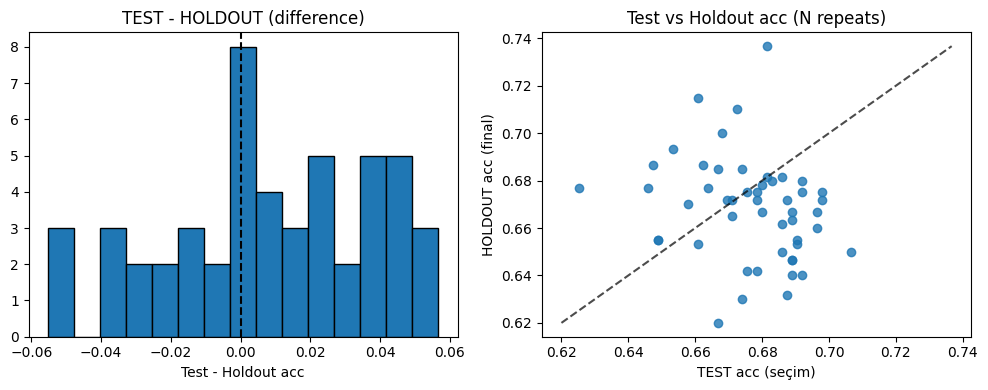

In [14]:
# Genişletilmiş grid + N tekrar deney hücresi
import matplotlib.pyplot as plt

# Yeni grid (daha geniş C aralığı), l1_ratio aynı tutuldu
c_grid2 = [0.001, 0.003, 0.01, 0.03, 0.1, 0.3, 1, 3, 10, 30]
l1_ratio_grid2 = [0.0, 1.0]

N = 50
rng_local = np.random.default_rng(12345)

test_accs = []
holdout_accs = []
selected_cfgs = []

def run_one_iteration(seed):
    # 1) final holdout ayır
    X_rest, X_holdout, y_rest, y_holdout = train_test_split(X, y, test_size=0.10, random_state=int(seed))
    # 2) kalan veriyi train/val/test (tuning test'i) olarak böl
    X_train2, X_temp2, y_train2, y_temp2 = train_test_split(X_rest, y_rest, test_size=0.25, random_state=int(seed+1))
    X_val2, X_test2, y_val2, y_test2 = train_test_split(X_temp2, y_temp2, test_size=0.5, random_state=int(seed+2))

    # train+val birleşimi for final training later
    X_trainval2 = np.vstack([X_train2, X_val2])
    y_trainval2 = np.hstack([y_train2, y_val2])

    # tuning (WRONG): choose model according to performance on X_test2
    best_model_local = None
    best_cfg_local = None
    best_test_acc_local = -1

    for C in c_grid2:
        for l1_ratio in l1_ratio_grid2:
            m = make_model(C, l1_ratio)
            _, test_acc = evaluate(m, X_train2, y_train2, X_test2, y_test2)
            if test_acc > best_test_acc_local:
                best_test_acc_local = test_acc
                best_cfg_local = (C, l1_ratio)
                best_model_local = m

    # final evaluation on untouched holdout
    _, holdout_acc_local = evaluate(best_model_local, X_trainval2, y_trainval2, X_holdout, y_holdout)

    return best_test_acc_local, holdout_acc_local, best_cfg_local

# Run N iterations
for i in range(N):
    seed = rng_local.integers(0, 10_000_000)
    t_acc, h_acc, cfg = run_one_iteration(seed)
    test_accs.append(t_acc)
    holdout_accs.append(h_acc)
    selected_cfgs.append(cfg)

test_accs = np.array(test_accs)
holdout_accs = np.array(holdout_accs)
diffs = test_accs - holdout_accs

# Summary
print(f"N = {N} deneme")
print(f"Ortalama TEST acc:    {test_accs.mean():.4f} ± {test_accs.std():.4f}")
print(f"Ortalama HOLDOUT acc: {holdout_accs.mean():.4f} ± {holdout_accs.std():.4f}")
print(f"Ortalama (TEST - HOLDOUT): {diffs.mean():.4f} ± {diffs.std():.4f}")
print(f"TEST>HOLDOUT sayısı: {(diffs>0).sum()} / {N}")

# Plot histogram of differences
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.hist(diffs, bins=15, color='C0', edgecolor='k')
plt.axvline(0, color='k', linestyle='--')
plt.title('TEST - HOLDOUT (difference)')
plt.xlabel('Test - Holdout acc')

# Scatter: test vs holdout
plt.subplot(1,2,2)
plt.scatter(test_accs, holdout_accs, alpha=0.8)
minv = min(test_accs.min(), holdout_accs.min())
maxv = max(test_accs.max(), holdout_accs.max())
plt.plot([minv, maxv], [minv, maxv], 'k--', alpha=0.7)
plt.xlabel('TEST acc (seçim)')
plt.ylabel('HOLDOUT acc (final)')
plt.title('Test vs Holdout acc (N repeats)')
plt.tight_layout()
plt.show()

Sonuç özeti ✅
- N = 50 tekrar çalıştırıldı (genişletilmiş grid: c_grid2, l1_ratio_grid2).

- Özet sonuçlar:
    - Ortalama TEST acc: 0.6765 ± 0.0162
    - Ortalama HOLDOUT acc: 0.6683 ± 0.0217
    - Ortalama (TEST − HOLDOUT): 0.0082 ± 0.0300
    - TEST > HOLDOUT: 32 / 50 iterasyonda

Yorum (kısa) 💡
- Test'te seçilen model çoğunlukla holdout üzerinde biraz daha iyi gözüküyor, ama fark küçük (ortalama 0.8 puan) ve dağılımın standart sapması yüksek (3 puan).
- Bu, tuning'in bazı durumlarda holdout'a kıyasla yanıltıcı olduğunu ama veri/model kombinasyonunda etki her zaman büyük olmayabilir demektir.

Öneriler — hangi ek analizi istersin? 🔧

    ✅ "En büyük fark" olan ilk 5 iterasyonu listeleyeyim (test, holdout, fark, seçilen (C,l1_ratio)).
    ✅ N'i artırayım (örn. N=200) ve güven aralığı hesaplayayım.
    ✅ Grid'i daha da genişletip/karmaşık modele geçirip farkın büyüyüp büyümediğine bakayım.
    ✅ Nested CV ile seçim yanlılığını nicelendirip raporlayayım.